# Cointegration Example in Multivariate Time Series

## Review 


- Augmented Dickey Fuller test
- Johansen Test for Cointegration 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
%pylab inline
pylab.rcParams['figure.figsize'] = (18.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


Generate three series with a normal distribution (0, 1)

In [2]:
mu = 0
sigma = 1
n = 10000
np.random.seed(42)
s1 = list(np.random.normal(mu, sigma, n))
s2 = np.random.normal(mu, sigma, n)
s3 = np.random.normal(mu, sigma, n)
s4 = np.random.normal(mu, sigma, n)

C:\Users\686114\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


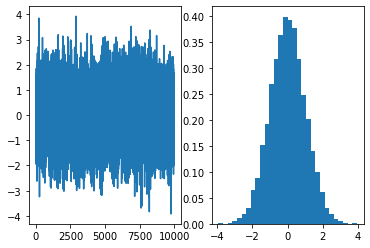

In [3]:
s = s1
plt.figure(1)
plt.subplot(121)
plt.plot(s)
plt.subplot(122)
plt.hist(s, 30, normed=True)
plt.show()

Create processes:

x_1t is I(2)  
x_2t is I(2)  
x_3t is I(1)  

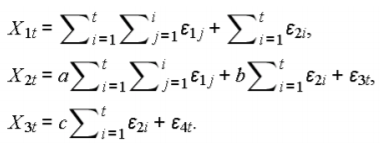

In [4]:
def sum_range(j, i, x):
    return np.cumsum(list(x[j:i]))

sum_range(0,5, list(range(1, 11)))

array([ 1,  3,  6, 10, 15], dtype=int32)

In [5]:

def sumofsum(x):
    a = np.array(x)
    for i in range(0, len(x)+1):
        a = np.cumsum(sum_range(0, i, x))
    return a


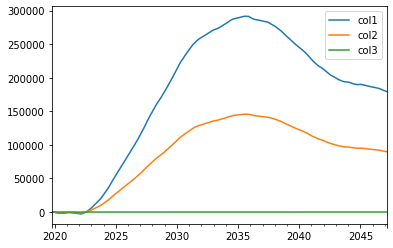

In [6]:
a = 0.5
b = 0.4
c = 0.3

# [a, -1, 0]
va = [0.5,-1, 0]
# [ac, −c, −(a − b)]
vb = [a*c, -c, -(a-b)]

x_1t = sumofsum(s1) + np.cumsum(s3)
x_2t = a*sumofsum(s1) + b*np.cumsum(s2) + s3
x_3t = c*np.cumsum(s2) + s4

todays_date = datetime.datetime.now().date()
#Create date daily index from 10 days before today until 'n'
index = pd.date_range(todays_date-datetime.timedelta(10), periods=n, freq='D')
y = pd.DataFrame(index=index, data={'col1': x_1t, 'col2': x_2t, 'col3':x_3t} )
y.plot()

### Augmented Dickey Fuller test

In [14]:
def ADF(v, crit='5%', max_d=6, reg='nc', autolag='AIC'):
    """ Augmented Dickey Fuller test

    Parameters
    ----------
    v: ndarray matrix
        residuals matrix

    Returns
    -------
    bool: boolean
        true if v passes the test 
    """

    boolean = False

    
    adf = adfuller(v, max_d, reg, autolag)
    #print(adf)
    print(adf[0], '>', adf[4][crit], ' ?')
    if(adf[0] < adf[4][crit]):
        pass
    else:
        boolean = True

    return boolean

### Testing Unit root

In [15]:
print(ADF(x_1t))   # unit root hypothesis can't be rejected
print(ADF(np.diff(x_1t,1)))
print(ADF(x_2t))   # unit root hypothesis can't be rejected
print(ADF(np.diff(x_2t,1)))
print(ADF(x_3t))   # unit root hypothesis can't be rejected

-1.3970864860582037 > -1.9410269124810415  ?
True
-0.9022599376819164 > -1.9410269124810415  ?
True
-1.4254765570489873 > -1.9410269124810415  ?
True
-0.8683215711297543 > -1.9410269151778108  ?
True
0.16548017753212774 > -1.9410269124810415  ?
True


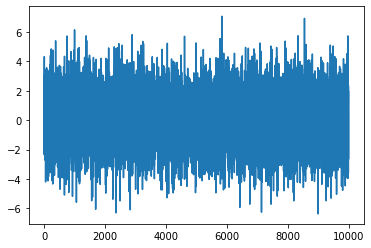

In [16]:
ydiff = pd.DataFrame(data={'col1diff': np.diff(x_1t,2), 'col2diff': np.diff(x_2t,2), 'col3diff': np.diff(x_3t, 2)})
plot(ydiff['col1diff'])

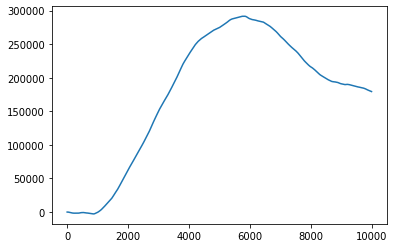

In [17]:
plot(x_1t)

### Johansen Function

Perform Johansen Cointegration Test and check which trace values are over the critical values at 95% confidence interval

In [11]:
def get_johansen(y, p):
        """
        Get the cointegration vectors at 95% level of significance
        given by the trace statistic test.
        """
        """
        H0: no cointegrating equation -> No cointegrating vectors
        H1: H0 is not true
        """
        N, l = y.shape
        jres = coint_johansen(y, 0, p)
        
        print("Critical values (90%, 95%, 99%) of maximum eigenvalue statistic.: ")
        print(jres.cvm, "\n")

        print("Critical values (90%, 95%, 99%) of trace statistic:")
        print(jres.cvt, "\n")

        print("Eigenvalues of VECM coefficient matrix:")
        print(jres.eig, "\n")

        print("Eigenvectors of VECM coefficient matrix:")
        print(jres.evec, "\n")

        print("Trace statistic:")
        print(jres.lr1, "\n")

        print("Maximum eigenvalue statistic:")
        print(jres.lr2, "\n")

        print("Test method:")
        print(jres.meth, "\n")

        print("Residuals for ΔY.:")
        print(jres.r0t, "\n")

        print("Residuals for Y−1:")
        print(jres.rkt, "\n")
        
        
        trstat = jres.lr1                       # trace statistic
        tsignf = jres.cvt                       # critical values
        
        """
        IF the trace statistic for each series is greater than the critical value THEN:
        that corresponding eigenvector is a cointegration vector
        """
        for i in range(l):
            if trstat[i] > tsignf[i, 1]:     # 0:90%  1:95%  2:99%
                r = i + 1
        jres.r = r
        jres.evecr = jres.evec[:, :r]

        return jres

Found two cointegration vectors, at first they don't seem close to the desired results.

In [23]:
p=2
jres=get_johansen(y,p)
print("There are ", jres.r, "cointegration vectors")
v1=jres.evecr[:,0]
print(v1)
v2=jres.evecr[:,1]
print(v2)
v3=jres.evecr[:,2]
print(v3)

Critical values (90%, 95%, 99%) of maximum eigenvalue statistic.: 
[[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values (90%, 95%, 99%) of trace statistic:
[[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 

Eigenvalues of VECM coefficient matrix:
[0.00596206 0.00085722 0.00020974] 

Eigenvectors of VECM coefficient matrix:
[[ 0.04278735  0.00075121 -0.01939949]
 [-0.08557598 -0.00147969  0.03878591]
 [ 0.24406374 -0.00422329  0.00570429]] 

Trace statistic:
[70.45131362 10.67021915  2.09694218] 

Maximum eigenvalue statistic:
[59.78109447  8.57327697  2.09694218] 

Test method:
johansen 

Residuals for ΔY.:
[[ 2.75000601  2.33517719  1.29802554]
 [-1.35912267 -0.60017637  1.86205139]
 [-0.01510482  0.19301891  0.35003286]
 ...
 [-2.45544389 -2.56304911  0.54441065]
 [-1.58616474 -1.27805879  0.82215467]
 [ 1.78437433  1.50813431 -0.37443936]] 

Residuals for Y−1:
[[-1.88625119e+05 -9.43680267e+04 -1.7719393

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
v1/-v1[1]

In [ ]:
v2/-v2[1]

In [ ]:
v3/-v3[1]

C:\Users\686114\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


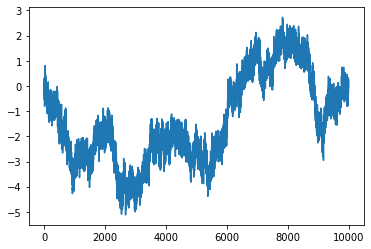

In [25]:
# If we apply vector v1 we get a I(0) time series
plot(np.dot(y.as_matrix(), v1))